In [15]:
import ast
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import BondType
import torch
import pandas as pd
import pickle
import re

# 필요한 함수 정의

1. 동적 matrix(adjacency, feature) 생성 함수

In [2]:
def smiles_to_graph(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    
    num_atoms = molecule.GetNumAtoms()
    
    adjacency = np.zeros((num_atoms, num_atoms), 'int64')
    features = np.zeros((num_atoms), 'int64')
    
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = atom_type
        
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[[i, j], [j, i]] = bond_type_idx
            
    adjacency = torch.tensor(adjacency.tolist(), dtype=torch.int8)
    features = torch.tensor(features.tolist(), dtype=torch.int8)
    
    return adjacency, features

2. adjacency, features 정보로 분자 복구하는 함수

In [3]:
def graph_to_molecule(features, adjacency):
    molecule = Chem.RWMol()  # 편집 가능한 빈 molecule 추가
    num_atoms = len(features)
    atom_index_map = {}
    
    # 'features' 이용해서 molecule에 atom 추가
    for i in range(num_atoms):
        atom_type = features[i].item() # Convert tensor to int
        atom_symbol = atom_mapping[atom_type]
        new_atom_index = molecule.AddAtom(Chem.Atom(atom_symbol))
        atom_index_map[i] = new_atom_index

    # 'adjacency' 이용해서 molecule에 bond 추가
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            bond_type_idx = adjacency[i, j].item()  # Convert tensor to int

            if bond_type_idx == 0:
                continue

            bond_type = bond_mapping[bond_type_idx]

            new_i = atom_index_map[i]
            new_j = atom_index_map[j]

            if bond_type != 0:
                molecule.AddBond(new_i, new_j, bond_type)

    return molecule

3. df 받아서 list of dict 생성<br>

!!! 추출하고자 하는 속성명 df 내 컬럼명과 동일하게 바꾸기 !!!

In [4]:
def generate_pickle(df):
    mol_list = []
    for index, row in df.iterrows():
        smiles = row['smiles']
        bp = row['bp']     ### 꼭 맞춰서 바꾸기!!!!!!###

        adjacency, features = smiles_to_graph(smiles)

        molecule_dict = {
            'num_atom' : adjacency.shape[0],
            'atom_type' : torch.tensor(features, dtype=torch.int8),
            'bond_type' : torch.tensor(adjacency, dtype=torch.int8),
            'bp' : torch.tensor([bp], dtype=torch.float32) ### 꼭 맞춰서 바꾸기!!!!!!###
        }

        mol_list.append(molecule_dict)
        
    return mol_list

# Data load

### From PubChem

In [5]:
data = pd.read_csv('../../1_DatasetForDescriptor/pubchem_boilingpoint.csv')

data.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation', 'bp'],
      dtype='object')

In [6]:
data2 = data[['canonicalsmiles', 'bp']]
data2.rename(columns={'canonicalsmiles':'smiles'}, inplace=True)

/tmp/ipykernel_5782/3103302929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.rename(columns={'canonicalsmiles':'smiles'}, inplace=True)


In [7]:
heavy_atoms = ['Ag', 'Al', 'Am', 'Ar', 'As', 'Au', 'Ba', 'Be', 'Bi', 'Ca', 'Cd', 'Ce', 'Co', 'Cr', 'Cs', 'Cu', 'Fe', 'Ga', 'Gd', 'Ge', 'He', 'Hf', 'Hg', 'In', 'Ir', 'K', 'Kr', 'La', 'Li', 'Mg', 'Mn', 'Mo', 'Na', 'Nb', 'Ne', 'Ni', 'Np', 'Os', 'Pb', 'Pd', 'Pt', 'Pu', 'Ra', 'Rh', 'Rn', 'Sb', 'Se', 'Si', 'Sm', 'Sn', 'Sr', 'Ta', 'Tb', 'Tc', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Xe', 'Y', 'Zn', 'Zr']

# Filter out rows with SMILES codes containing heavy atoms
df = data2[~data2['smiles'].str.contains('|'.join(heavy_atoms))]

# Reset the index of the filtered dataframe
df.reset_index(drop=True, inplace=True)

In [8]:
df['smiles']

0                                                 CC(CN)O
1               C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl
2                                                C(CCl)Cl
3                                   C1=CC(=C(C=C1Cl)Cl)Cl
4                               C1=CC(=C(C(=C1)O)O)C(=O)O
                              ...                        
5161                                    C[SH+]CCC(=O)[O-]
5162    CC1=NN=C(C=C1)N2C(C(=C(C3=CC=C(C=C3)C(C)C)O)C(...
5163    CCCN(CCC1CCC(CC1)CC(=O)C=CC2=CC=C(C=C2)OC)C3CC...
5164    CC(C)(C)C=C1CCCC(C1)O.CC(C)(C)C=C1CCCC(C1)O.CC...
5165    C=C1CC2(CCN(C2)C3=CC=CC=N3)C(=O)N1.C=C1CC2(CCN...
Name: smiles, Length: 5166, dtype: object

# Canonicalize + MolFromSmiles 안되는 smiles 삭제

In [9]:
# 서현님이 사용하신 코드로 canonicalize 를 해보려했지만, 구조가 valid 하지 않은것들이 있어서 drop 시행.
# Explict valence ... 경고문구를 출력하는 smiles 는 MolFromSmiles 로 molecule 이 생성되지 않음.
# molecule 이 생성되지 않으니 rdkit으로 atom_num 등 출력 불가능 -> 갯수도 4개 뿐이니 그냥 drop.
molecules = [Chem.MolFromSmiles(i) for i in df['smiles']]

[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:40:39] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:40:39] Explicit valence for atom # 1 Br, 3, is greater than permitted
[16:40:39] Explicit valence for atom # 1 Br, 5, is greater than permitted
[16:40:39] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:40:39] WARNING: not removing hydrogen atom without

In [11]:
drop_list = list()

for idx, smi in enumerate(df['smiles']):
    mol = Chem.MolFromSmiles(smi)
    if mol == None:
        drop_list.append(idx)
        print(f"index: {idx}, smiles: {smi}")

print(drop_list)
df = df.drop(index=drop_list, axis=0)
df

[16:41:19] WARNING: not removing hydrogen atom without neighbors
[16:41:19] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[16:41:19] WARNING: not removing hydrogen atom without neighbors
[16:41:19] Explicit valence for atom # 1 Br, 3, is greater than permitted
[16:41:19] Explicit valence for atom # 1 Br, 5, is greater than permitted
[16:41:19] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[16:41:19] WARNING: not removing hydrogen atom without neighbors


index: 2599, smiles: O=Cl(=O)(=O)F
index: 2623, smiles: FBr(F)F
index: 2626, smiles: FBr(F)(F)(F)F
index: 2629, smiles: FCl(F)F
[2599, 2623, 2626, 2629]


[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not removing hydrogen atom without neighbors
[16:41:20] WARNING: not r

,smiles,bp
0,CC(CN)O,156
1,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,315
2,C(CCl)Cl,83
3,C1=CC(=C(C=C1Cl)Cl)Cl,212
4,C1=CC(=C(C(=C1)O)O)C(=O)O,362
...,...,...
5161,C[SH+]CCC(=O)[O-],244
5162,CC1=NN=C(C=C1)N2C(C(=C(C3=CC=C(C=C3)C(C)C)O)C(...,340
5163,CCCN(CCC1CCC(CC1)CC(=O)C=CC2=CC=C(C=C2)OC)C3CC...,205
5164,CC(C)(C)C=C1CCCC(C1)O.CC(C)(C)C=C1CCCC(C1)O.CC...,204


In [12]:
# drop 한 smiles index 때문에 중간에 데이터가 비어서 reset_index 시행
df = df.reset_index(drop=True)
df

,smiles,bp
0,CC(CN)O,156
1,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,315
2,C(CCl)Cl,83
3,C1=CC(=C(C=C1Cl)Cl)Cl,212
4,C1=CC(=C(C(=C1)O)O)C(=O)O,362
...,...,...
5157,C[SH+]CCC(=O)[O-],244
5158,CC1=NN=C(C=C1)N2C(C(=C(C3=CC=C(C=C3)C(C)C)O)C(...,340
5159,CCCN(CCC1CCC(CC1)CC(=O)C=CC2=CC=C(C=C2)OC)C3CC...,205
5160,CC(C)(C)C=C1CCCC(C1)O.CC(C)(C)C=C1CCCC(C1)O.CC...,204


In [13]:
# 문제있는 smiles 를 drop 했으니 다시 실행 -> canonicalize
df['smiles'] = df['smiles'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df

[16:41:33] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not removing hydrogen atom without neighbors
[16:41:34] WARNING: not r

,smiles,bp
0,CC(O)CN,156
1,O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1,315
2,ClCCCl,83
3,Clc1ccc(Cl)c(Cl)c1,212
4,O=C(O)c1cccc(O)c1O,362
...,...,...
5157,C[SH+]CCC(=O)[O-],244
5158,CC(=O)c1ccc(C2C(=C(O)c3ccc(C(C)C)cc3)C(=O)C(=O...,340
5159,CCCN(CCC1CCC(CC(=O)C=Cc2ccc(OC)cc2)CC1)C1CCc2n...,205
5160,CC(C)(C)C=C1CCCC(O)C1.CC(C)(C)C=C1CCCC(O)C1.CC...,204


In [87]:
# 혹시모르니 저장한번 할께요
df.to_csv('pubchem_bp_v1.csv')

In [16]:
# atom_type(SMILES_CHARSET) 생성
atom_type = list()

for smi in df['smiles']:
    mol = Chem.MolFromSmiles(smi)
    for at in mol.GetAtoms():
        if at.GetSymbol() not in atom_type:
            atom_type.append(at.GetSymbol())
            
SMILE_CHARSET = atom_type.copy()
SMILE_CHARSET

[16:45:00] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not removing hydrogen atom without neighbors
[16:45:01] WARNING: not r

['C', 'O', 'N', 'Cl', 'Br', 'S', 'H', 'I', 'P', 'F', 'B']

In [20]:
# HOMO, LUMO dataset과 겹치는 atom은 mapping number가 같아야 하므로 순서 재정렬함. Tox data의 SMILE_CHARSET과 동일함
SMILE_CHARSET = ['C', 'F', 'H', 'N', 'O', 'B', 'Br', 'Cl', 'I', 'P', 'S']
SMILE_CHARSET

['C', 'F', 'H', 'N', 'O', 'B', 'Br', 'Cl', 'I', 'P', 'S']

In [21]:
from rdkit.Chem.Draw import MolsToGridImage

[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not removing hydrogen atom without neighbors
[16:48:39] WARNING: not r

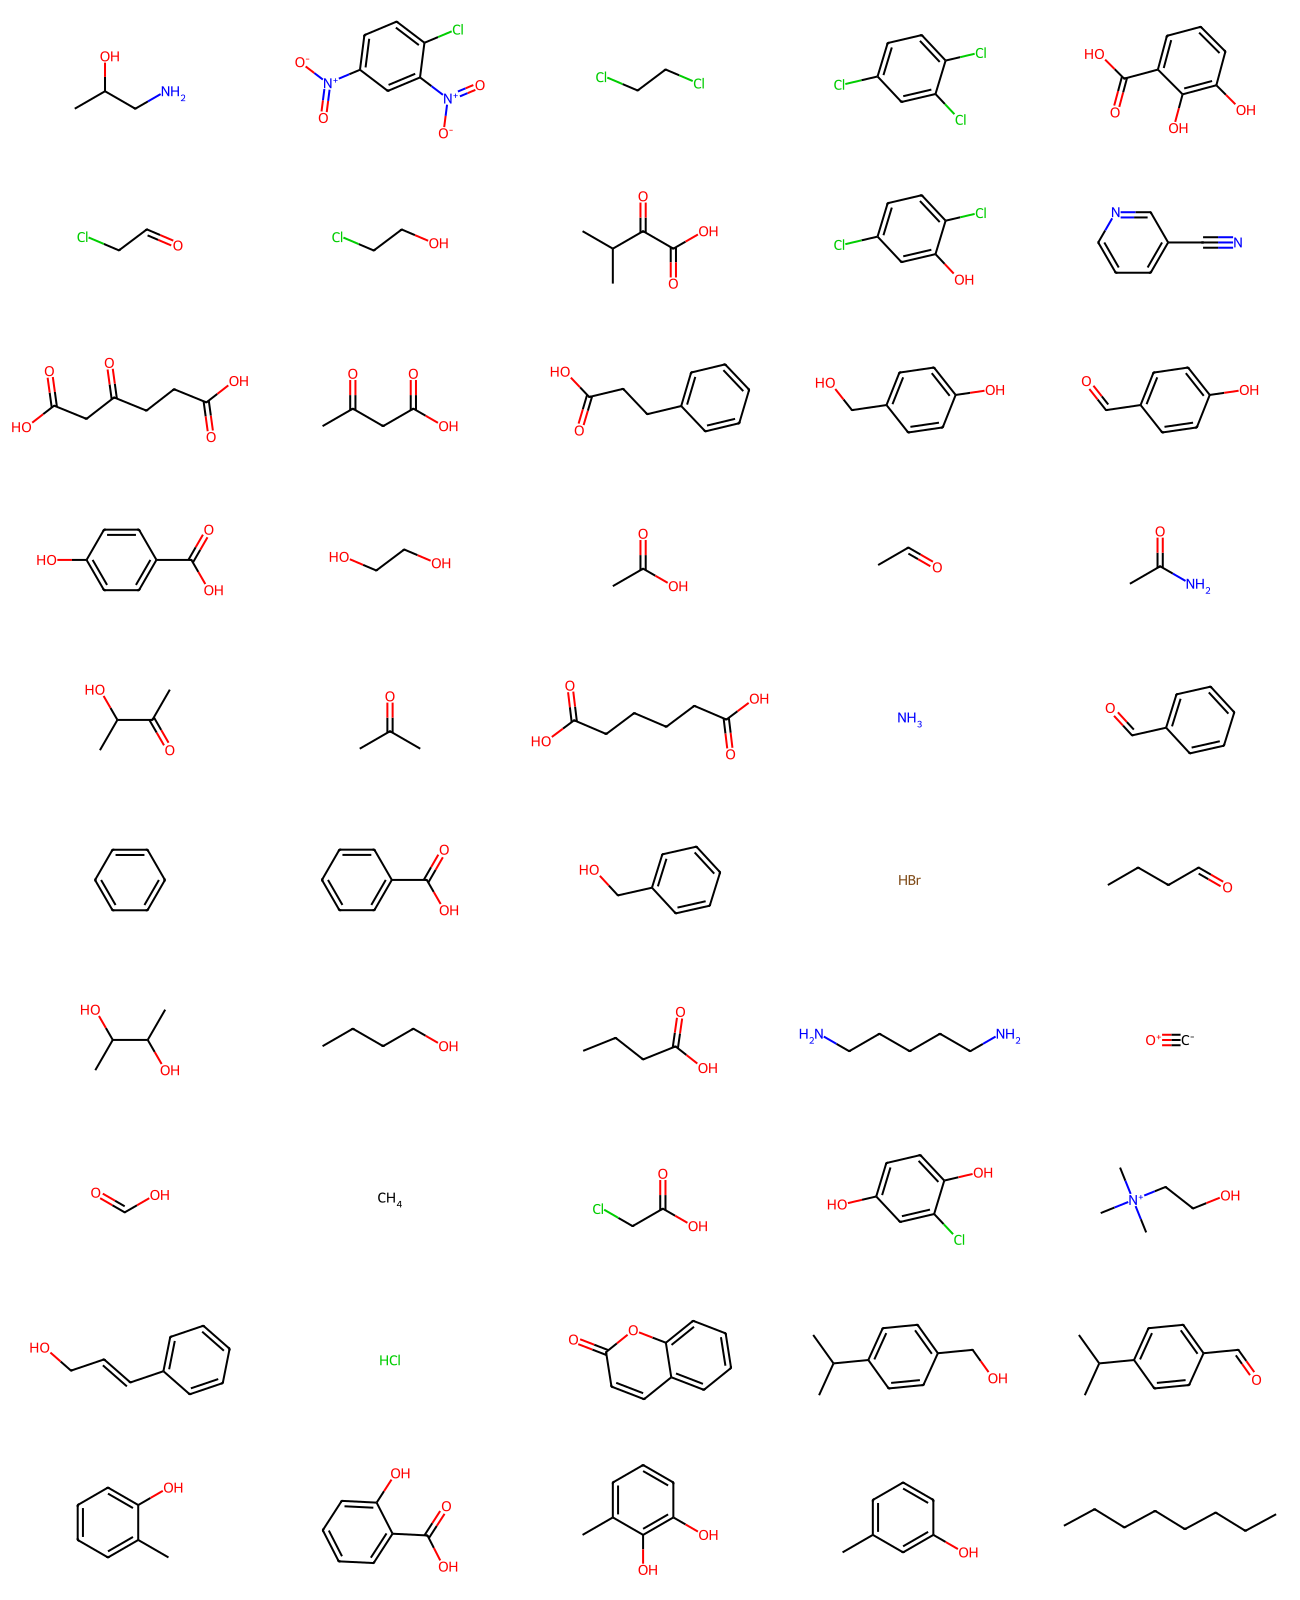

In [22]:
molecules = [Chem.MolFromSmiles(i) for i in df['smiles']]


MolsToGridImage(
    [m for m in molecules if m is not None][:1000], molsPerRow=5, subImgSize=(260, 160)
)

# bond, atom Dictionary  생성

In [23]:
# bond_mapping Dictionary 생성
bond_mapping = {"SINGLE": 1, "DOUBLE": 2, "TRIPLE": 3, "AROMATIC": 4}
bond_mapping.update({1:BondType.SINGLE, 2: BondType.DOUBLE, 3: BondType.TRIPLE, 4: BondType.AROMATIC})

# 새로운 DF의 'smiles' 컬럼에서 원자 종류 뽑는 과정
# atom_type = df['smiles'].apply(lambda x: [symbol for symbol in x if symbol.isalpha()]).explode().unique()
# SMILE_CHARSET = atom_type.tolist()
# SMILE_CHARSET.sort()
# print('SMILE_CHARSET: ', SMILE_CHARSET)

# atom_mapping_Dictionary 생성
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)
print('atom_mapping: ', atom_mapping)

atom_mapping:  {'C': 0, 'F': 1, 'H': 2, 'N': 3, 'O': 4, 'B': 5, 'Br': 6, 'Cl': 7, 'I': 8, 'P': 9, 'S': 10, 0: 'C', 1: 'F', 2: 'H', 3: 'N', 4: 'O', 5: 'B', 6: 'Br', 7: 'Cl', 8: 'I', 9: 'P', 10: 'S'}


# Train, Val, Test 분리

In [24]:
from sklearn.model_selection import train_test_split

shuffled_indices = df.sample(frac=1, random_state=100).index
shuffled_df = df.sample(frac=1, random_state=100)

train_ratio = 0.9
val_ratio = 0.07
test_ratio = 0.03

# train, val, test indices 분리
train_indices, val_test_indices = train_test_split(shuffled_indices, 
                                                   train_size=train_ratio, 
                                                   test_size=val_ratio+test_ratio, 
                                                   random_state=100)
val_indices, test_indices = train_test_split(val_test_indices, 
                                             train_size=val_ratio/(val_ratio+test_ratio), 
                                             test_size=test_ratio/(val_ratio+test_ratio), 
                                             random_state=100)

# train, val, test data 분리
train_data = df.loc[train_indices]
val_data = df.loc[val_indices]
test_data = df.loc[test_indices]

print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 4645
Validation set size: 361
Test set size: 156


In [25]:
print("Train indices length:", len(train_indices))
print("Validation indices length:", len(val_indices))
print("Test indices length:", len(test_indices))

Train indices length: 4645
Validation indices length: 361
Test indices length: 156


# 각 데이터셋으로 Dict 생성

In [26]:
print('Generating train_list_of_dict...')
train_list_of_dict = generate_pickle(train_data)
print('train_list_of_dict generated')

print('Generating val_list_of_dict...')
val_list_of_dict = generate_pickle(val_data)
print('val_list_of_dict generated')

print('Generating test_list_of_dict...')
test_list_of_dict = generate_pickle(test_data)
print('test_list_of_dict generated')

Generating train_list_of_dict...


/tmp/ipykernel_5782/1317163245.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'atom_type' : torch.tensor(features, dtype=torch.int8),
/tmp/ipykernel_5782/1317163245.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'bond_type' : torch.tensor(adjacency, dtype=torch.int8),
[16:49:36] WARNING: not removing hydrogen atom without neighbors
[16:49:36] WARNING: not removing hydrogen atom without neighbors
[16:49:37] WARNING: not removing hydrogen atom without neighbors
[16:49:37] WARNING: not removing hydrogen atom without neighbors
[16:49:37] WARNING: not removing hydrogen atom without neighbors
[16:49:37] WARNING: not removing hydrogen atom without neighbors
[16:49:37] WARNING: not r

train_list_of_dict generated
Generating val_list_of_dict...
val_list_of_dict generated
Generating test_list_of_dict...
test_list_of_dict generated


[16:49:38] WARNING: not removing hydrogen atom without neighbors
[16:49:38] WARNING: not removing hydrogen atom without neighbors
[16:49:38] WARNING: not removing hydrogen atom without neighbors


# index, pickle 저장

!!! 경로 수정 !!!

In [27]:
pwd

'/home/sjang/MILESTONE/2_GeneratePickles/0_codes'

In [28]:
# Define the file paths for saving the data and indices
file_path = "/home/sjang/MILESTONE/2_GeneratePickles/4_boilingpoint/"

train_data_path = file_path + "train.pickle"
val_data_path = file_path + "val.pickle"
test_data_path = file_path + "test.pickle"


# Save train data
with open(train_data_path, 'wb') as f:
    pickle.dump(train_list_of_dict, f)

# Save validation data
with open(val_data_path, 'wb') as f:
    pickle.dump(val_list_of_dict, f)

# Save test data
with open(test_data_path, 'wb') as f:
    pickle.dump(test_list_of_dict, f)

In [29]:
train_data.head(3)

,smiles,bp
1260,C=COCCCC,94
3685,CC(O)C(C)O,77
4665,CCCCCC=CC=CC=O,279


In [30]:
train_indices[:3]

Index([1260, 3685, 4665], dtype='int64')

In [31]:
train_list_of_dict[:3]

[{'num_atom': 7,
  'atom_type': tensor([0, 0, 4, 0, 0, 0, 0], dtype=torch.int8),
  'bond_type': tensor([[0, 2, 0, 0, 0, 0, 0],
          [2, 0, 1, 0, 0, 0, 0],
          [0, 1, 0, 1, 0, 0, 0],
          [0, 0, 1, 0, 1, 0, 0],
          [0, 0, 0, 1, 0, 1, 0],
          [0, 0, 0, 0, 1, 0, 1],
          [0, 0, 0, 0, 0, 1, 0]], dtype=torch.int8),
  'bp': tensor([94.])},
 {'num_atom': 6,
  'atom_type': tensor([0, 0, 4, 0, 0, 4], dtype=torch.int8),
  'bond_type': tensor([[0, 1, 0, 0, 0, 0],
          [1, 0, 1, 1, 0, 0],
          [0, 1, 0, 0, 0, 0],
          [0, 1, 0, 0, 1, 1],
          [0, 0, 0, 1, 0, 0],
          [0, 0, 0, 1, 0, 0]], dtype=torch.int8),
  'bp': tensor([77.])},
 {'num_atom': 11,
  'atom_type': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4], dtype=torch.int8),
  'bond_type': tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 1, 

## 7월 21일 금요일 업데이트 목록
* MolFromSmiles 로 변환 안되던 smiles 4개 제거
* canonicalize - 제가 까먹고 안했던거 같아서 했습니다!
* 파일생성까지 잘되는거 확인했습니다!